# Table of Contents

1. [Introduction](#Introduction)
2. [Lorenz Atrractor ](#Lorenz-Atrractor)
3. [NeuralODE](#NeuralODE)
4. [Plotting Results](#Plotting-Results)
5. [Projection using Trained NeuralODE](#Projection-using-Trained-NeuralODE)
6. [Conclusions](#Conclusions)
6. [References](#References)

## Introduction

In [1]:
import torch
import numpy as np
import torch.cuda as cuda
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torchdiffeq

## Lorenz Atrractor

The Lorenz attractor is a well-known chaotic system that exhibits complex and unpredictable behavior. It was first studied by Edward Lorenz in 1963 and has since become a prominent example in the field of chaos theory.

The system is described by a set of three coupled ordinary differential equations, known as the Lorenz equations. These equations capture the dynamics of the system and govern the evolution of its state variables over time.

### Equations

The Lorenz equations are given by:

\[
\begin{align*}
\frac{{dx}}{{dt}} &= \sigma \cdot (y - x) \\
\frac{{dy}}{{dt}} &= x \cdot (\rho - z) - y \\
\frac{{dz}}{{dt}} &= x \cdot y - \beta \cdot z \\
\end{align*}
\]

where:
- $x, y, and z$ are the state variables representing the position of the system in three-dimensional space.
- where $\sigma, \rho, and \beta$ are constants that determine the behavior of the system. They control the system's sensitivity to initial conditions and its overall dynamics.

### Implementation

In the code cell, a function `lorenz(t, X)` is used to compute the derivatives of the state variables at a given time $t$ and  state  $X$. The function takes the following parameters:
- $t$: The current time.
- $X$: The current state, represented as a tensor with three elements $x, y, z$.

The function calculates the time derivatives of the variables $x$, $y$, and $z$ based on these equations.


In [2]:
def lorenz(t, X):
    sigma = 10.
    beta = 8/3
    rho = 28.
    if X.ndim == 1:
        x, y, z = X
    else:
        x, y, z = X.unbind(dim=-1)
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return torch.stack([xdot, ydot, zdot], dim=-1)

## Dataset Creation and Splitting into train and test set

The data is split by placing the $n^\text{th}$ step in X_train and the $(n+1)^\text{th}$ step in Y_train, following this pattern for each step.

In [3]:
# Initial conditions
x_0 = torch.tensor([1., 0., 0.])

# Define the time values
t_vals = torch.linspace(0., 450., 45000)

# Using ODE Solver to Integrate the function to get the data
sol = torchdiffeq.odeint(lorenz, x_0, t_vals)

X=sol
L = 35000  # Length of the training set

# Define the training set
X_train = X[:L]
Y_train = X[1:L+1]

# Define the test set
X_test = X[L:-1]
Y_test = X[L+1:]

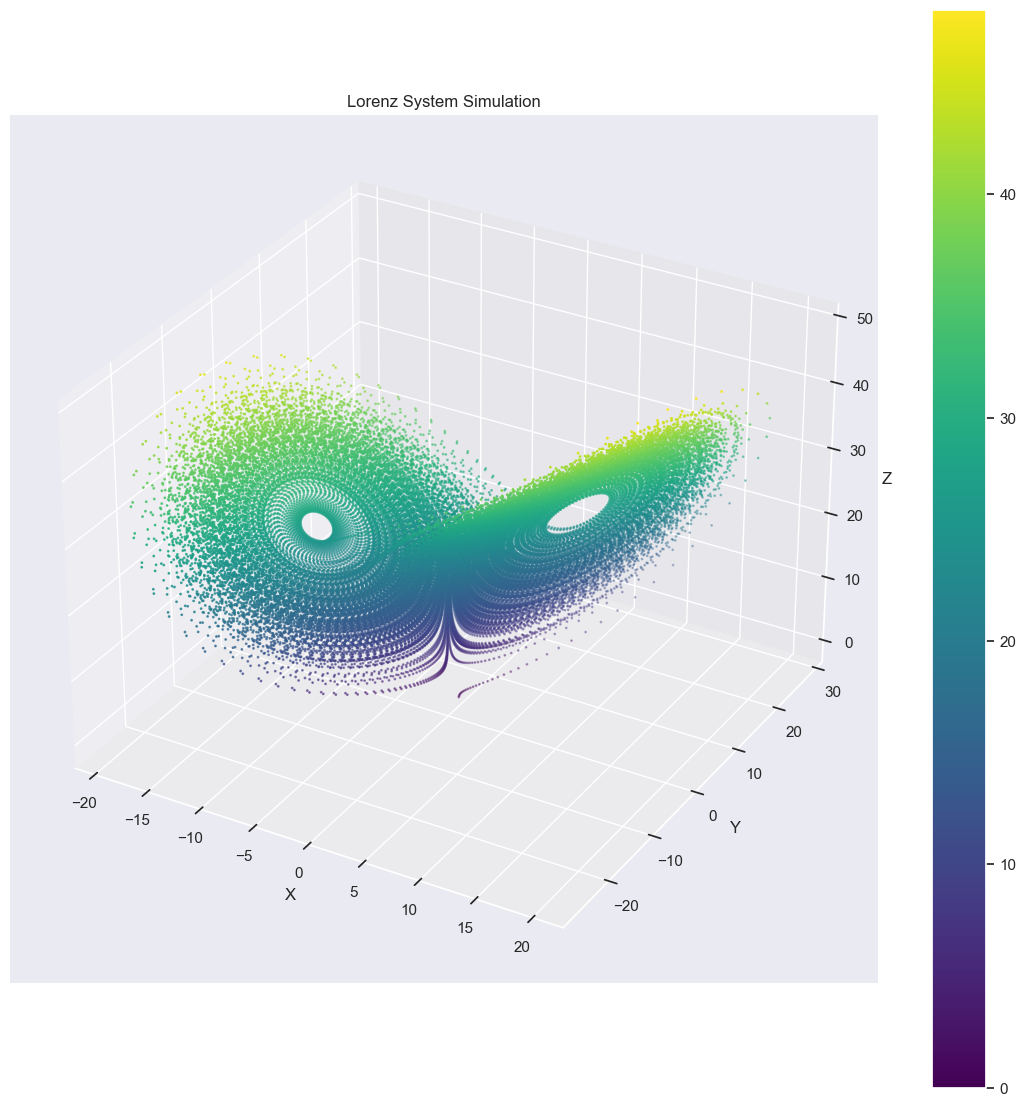

In [6]:
# Extract the x, y, z coordinates from the simulation results
x = X[:, 0].numpy()
y = X[:, 1].numpy()
z = X[:, 2].numpy()

# Set seaborn style
sns.set(style='darkgrid')

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=z, cmap='viridis', label='Lorenz attractor', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System Simulation')
cbar = fig.colorbar(sc)
plt.savefig('lorenz.png')
# Show the plot
plt.show()


## NeuralODE
Here we use Neural ODE approach to train the neural network for learning the dynamics of the Lorenz Attractor by using Backpropogation Through Time to calculate gradients and update the weights.


In [6]:
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Training Process

To train the Neural ODE, the following steps are performed:

1. **Initialization:** The network is initialized with the defined architecture.

2. **Loss Function:** The Mean Squared Error (MSE) loss function is used to measure the discrepancy between the predicted outputs and the ground truth values.

3. **Optimization:** The Adam optimizer is employed to update the network parameters based on the computed gradients.

4. **Training Loop:** The training process involves iterating over a fixed number of epochs (in this case, 1000). In each epoch:
   - Gradients are reset to zero.
   - A forward pass is performed through the network to obtain the predicted outputs.
   - The loss between the predicted outputs and the ground truth values is computed.
   - Backward propagation is used to compute the gradients.
   - The optimizer updates the network weights based on the gradients.
   - Optionally, the loss is printed after every 100 epochs to track the training progress.

5. **Final Loss:** After completing the training loop, the final loss is reported, indicating the convergence of the Neural ODE.


In [7]:
# Initialize the network
net = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

loss_list = []

for i in range(1000):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(X_train)

    # Compute the loss
    loss = criterion(outputs, Y_train)
    loss_list.append(loss.item())

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()
    # Print loss after every 100 epochs
    if (i + 1) % 100 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(i + 1, loss_list[-1]))

print("Final loss =", loss_list[-1])

Epoch: 100, Loss: 0.1848
Epoch: 200, Loss: 0.0401
Epoch: 300, Loss: 0.0152
Epoch: 400, Loss: 0.0075
Epoch: 500, Loss: 0.0046
Epoch: 600, Loss: 0.0034
Epoch: 700, Loss: 0.0027
Epoch: 800, Loss: 0.0024
Epoch: 900, Loss: 0.0021
Epoch: 1000, Loss: 0.0018
Final loss = 0.0017914428608492017


In [8]:
# Apply the predictor to all the points in the training set
train_predictions = net(X_train)

test_predictions = net(X_test)

## Plotting-Results

In [9]:
# Convert the predictions, test_predictions, and true values to numpy arrays
predictions_plt = train_predictions.detach().numpy()
test_predictions_plt = test_predictions.detach().numpy()
X_train_plt = X_train.detach().numpy()
X_test_plt = X_test.detach().numpy()

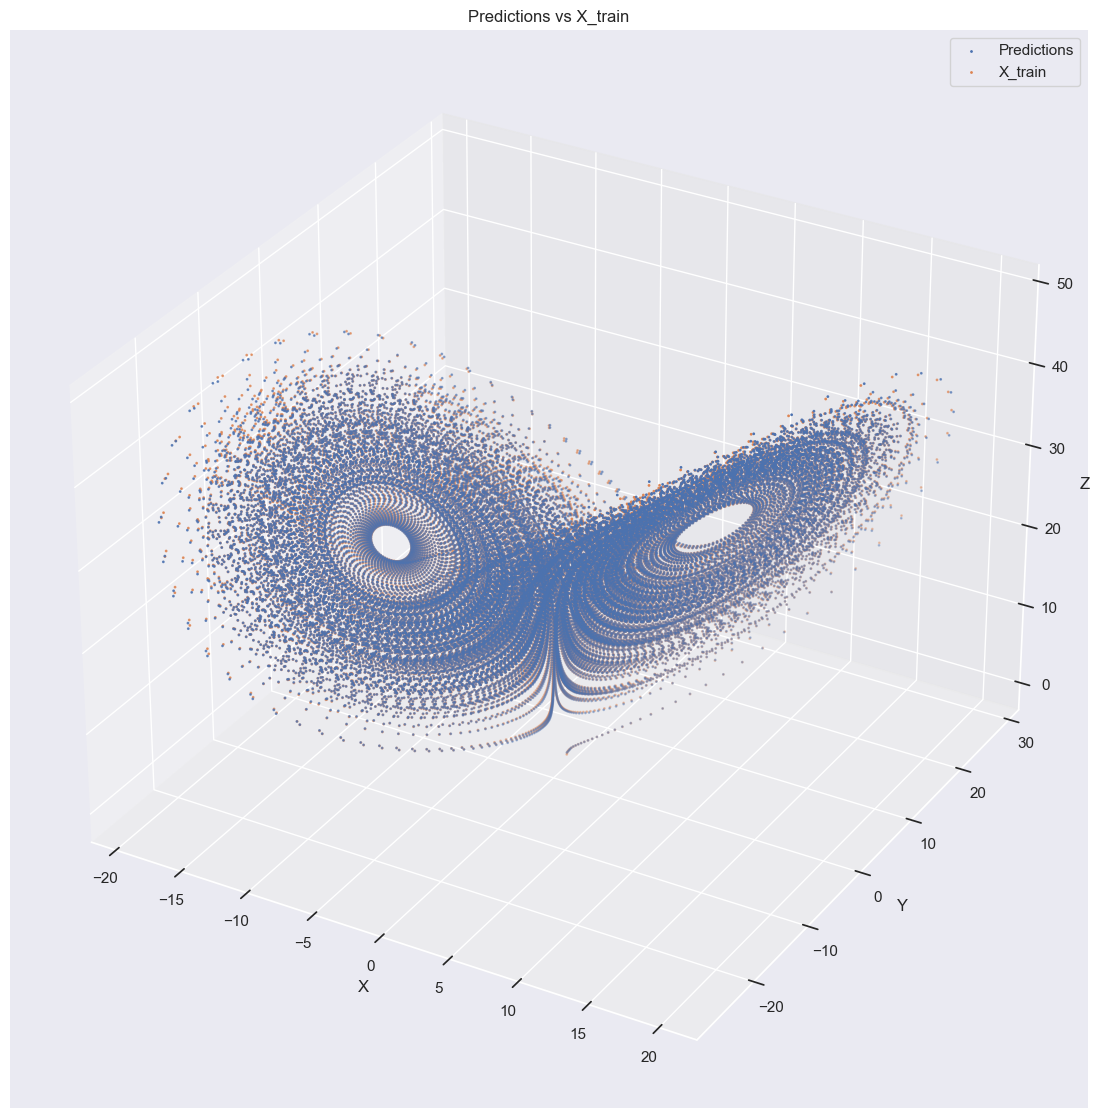

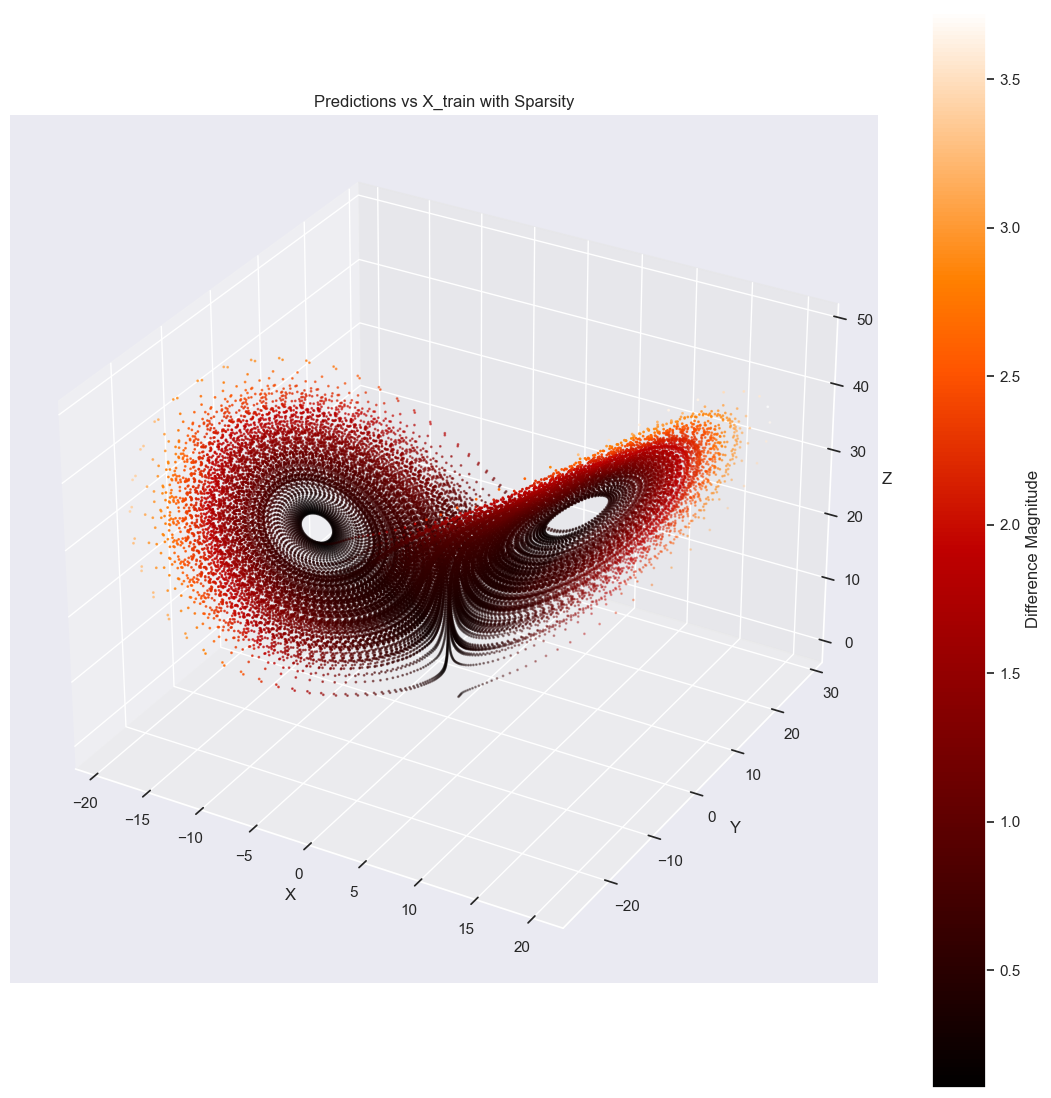

In [10]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = predictions_plt[:, 0]
y_pred = predictions_plt[:, 1]
z_pred = predictions_plt[:, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = X_train_plt[:, 0]
y_train = X_train_plt[:, 1]
z_train = X_train_plt[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=1)
ax.scatter(x_train, y_train, z_train, label='X_train',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predictions vs X_train')
ax.legend()

# Show the plot
plt.show()

diff_x = x_pred - x_train
diff_y = y_pred - y_train
diff_z = z_pred - z_train

# Calculate the magnitude of the differences
diff_mag = np.sqrt(diff_x**2 + diff_y**2 + diff_z**2)

# Define the color map for differences
cmap = plt.cm.get_cmap('gist_heat')  # Choose a colormap (e.g., 'cool')

# Create a 3D plot with sparsity in visualizing differences
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_pred, y_pred, z_pred, c=diff_mag, cmap=cmap, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predictions vs X_train with Sparsity')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Difference Magnitude')

# Show the plot
plt.show()






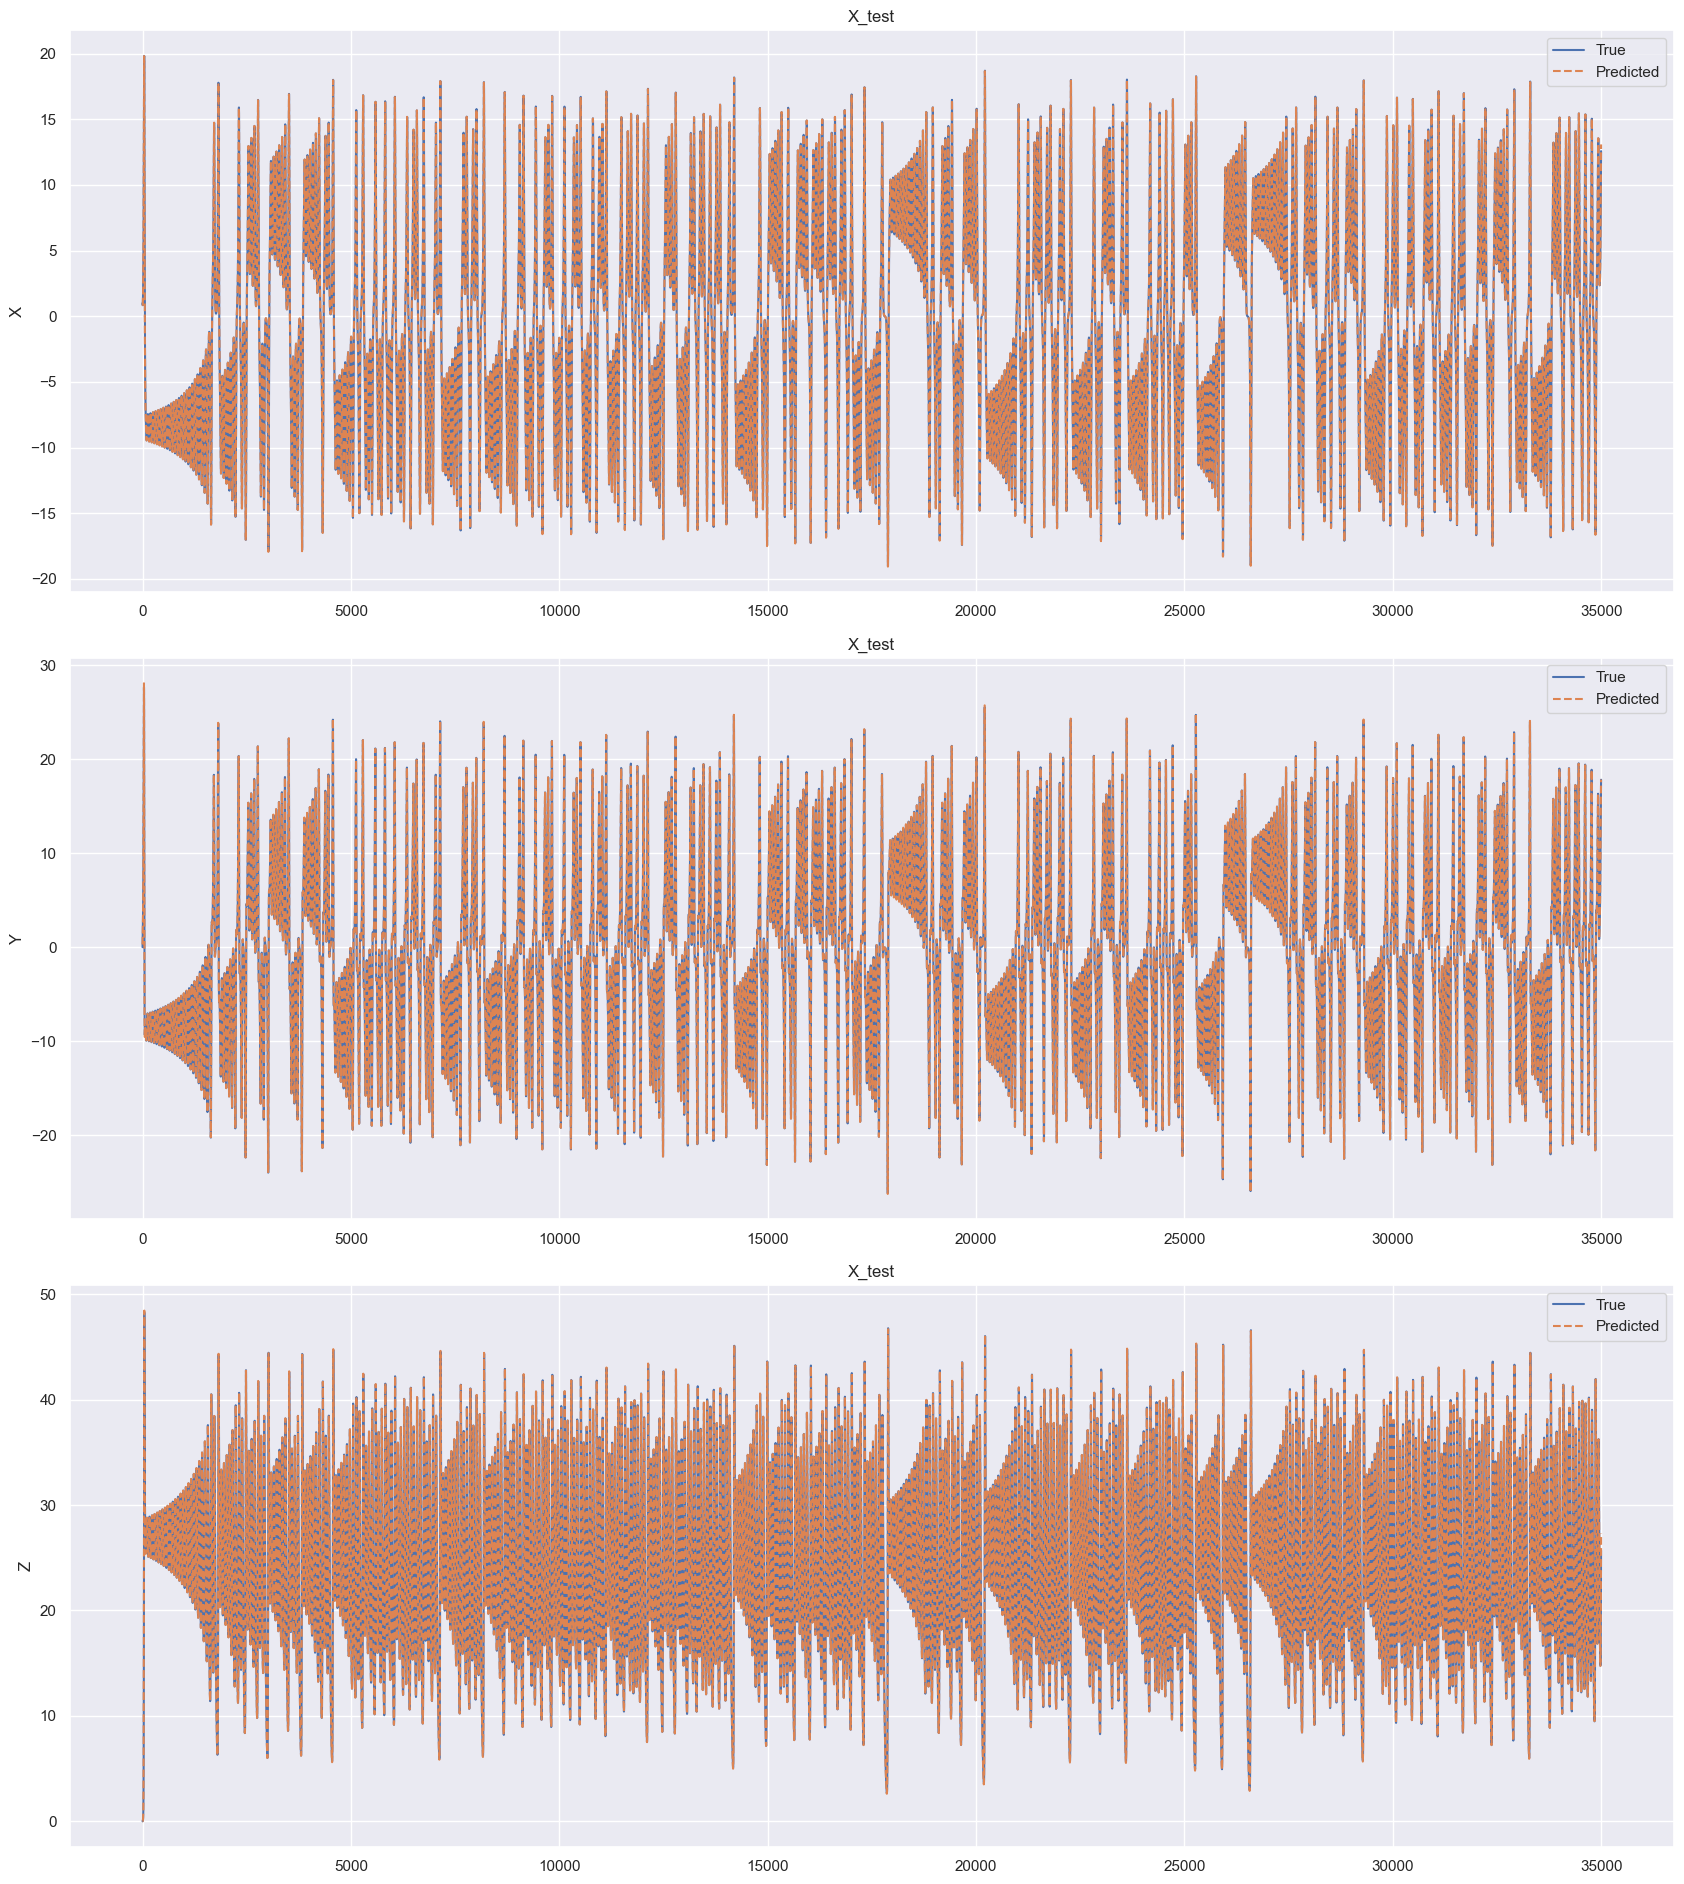

In [11]:
# Plot the predicted and true trajectories for X_test
fig, ax = plt.subplots(3, 1, figsize=(17, 19))
ax[0].plot(X_train_plt[:, 0], label='True')
ax[0].plot(predictions_plt[:, 0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
ax[0].set_title('X_test')
ax[0].legend()

ax[1].plot(X_train_plt[:, 1], label='True')
ax[1].plot(predictions_plt[:, 1], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('X_test')
ax[1].legend()

ax[2].plot(X_train_plt[:, 2], label='True')
ax[2].plot(predictions_plt[:, 2], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
ax[2].set_title('X_test')
ax[2].legend()

plt.tight_layout()
plt.show()

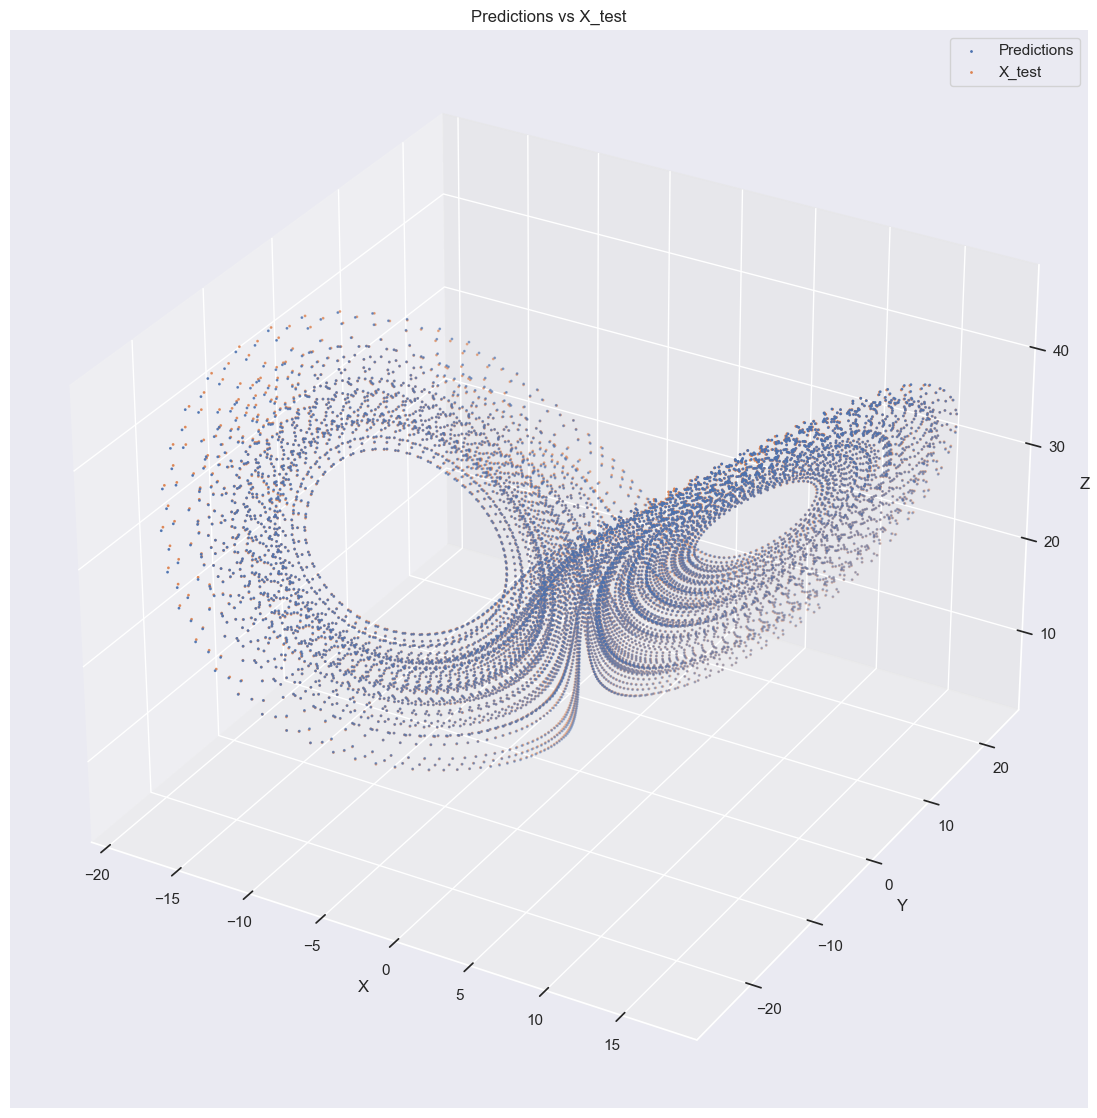

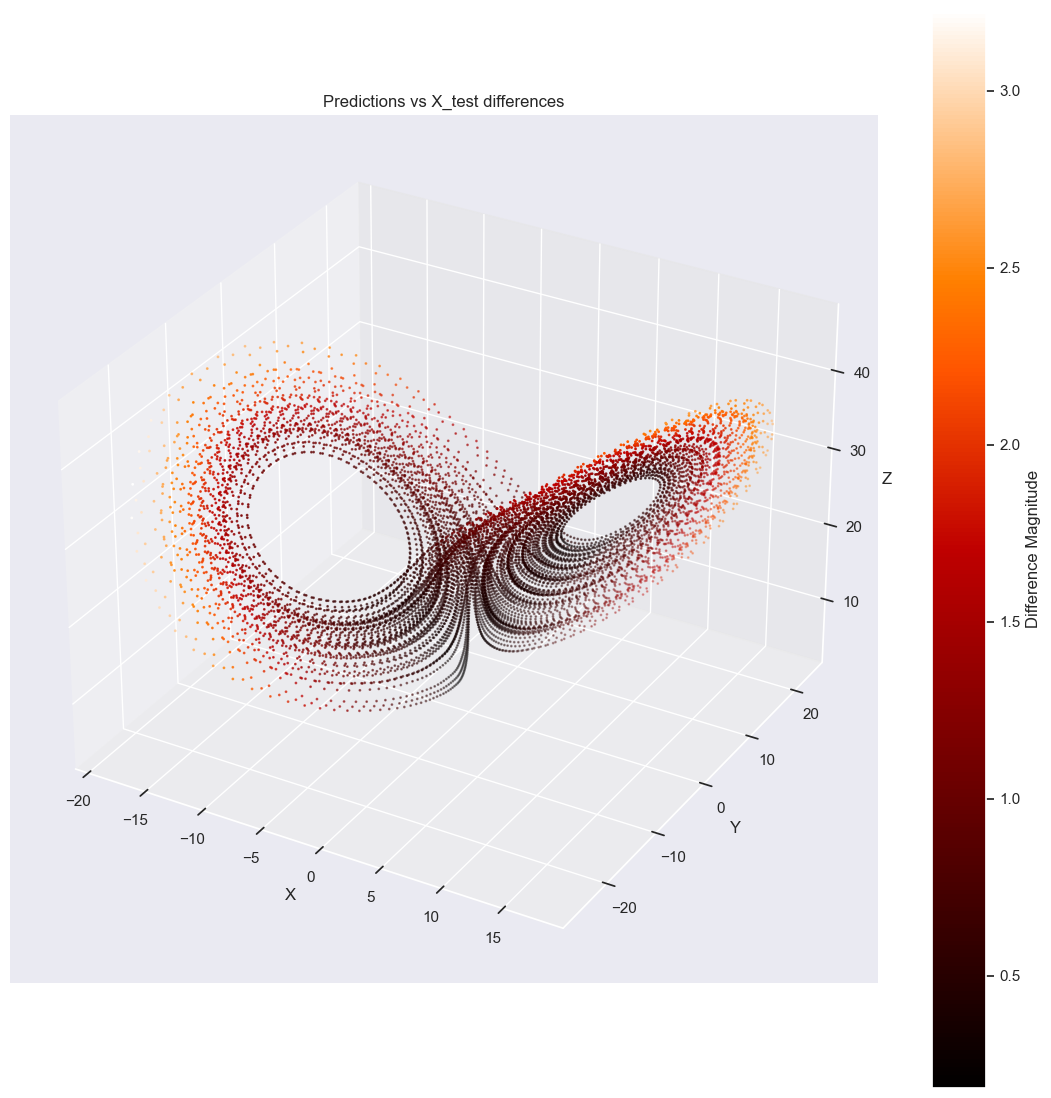

In [12]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = test_predictions_plt[:, 0]
y_pred = test_predictions_plt[:, 1]
z_pred = test_predictions_plt[:, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = X_test_plt[:, 0]
y_train = X_test_plt[:, 1]
z_train = X_test_plt[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=1)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predictions vs X_test')
ax.legend()

# Show the plot
plt.show()

diff_x = x_pred - x_train
diff_y = y_pred - y_train
diff_z = z_pred - z_train

# Calculate the magnitude of the differences
diff_mag = np.sqrt(diff_x**2 + diff_y**2 + diff_z**2)

# Define the color map for differences
cmap = plt.cm.get_cmap('gist_heat')  # Choose a colormap (e.g., 'cool')

# Create a 3D plot with sparsity in visualizing differences
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_pred, y_pred, z_pred, c=diff_mag, cmap=cmap, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predictions vs X_test differences')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Difference Magnitude')

# Show the plot
plt.show()






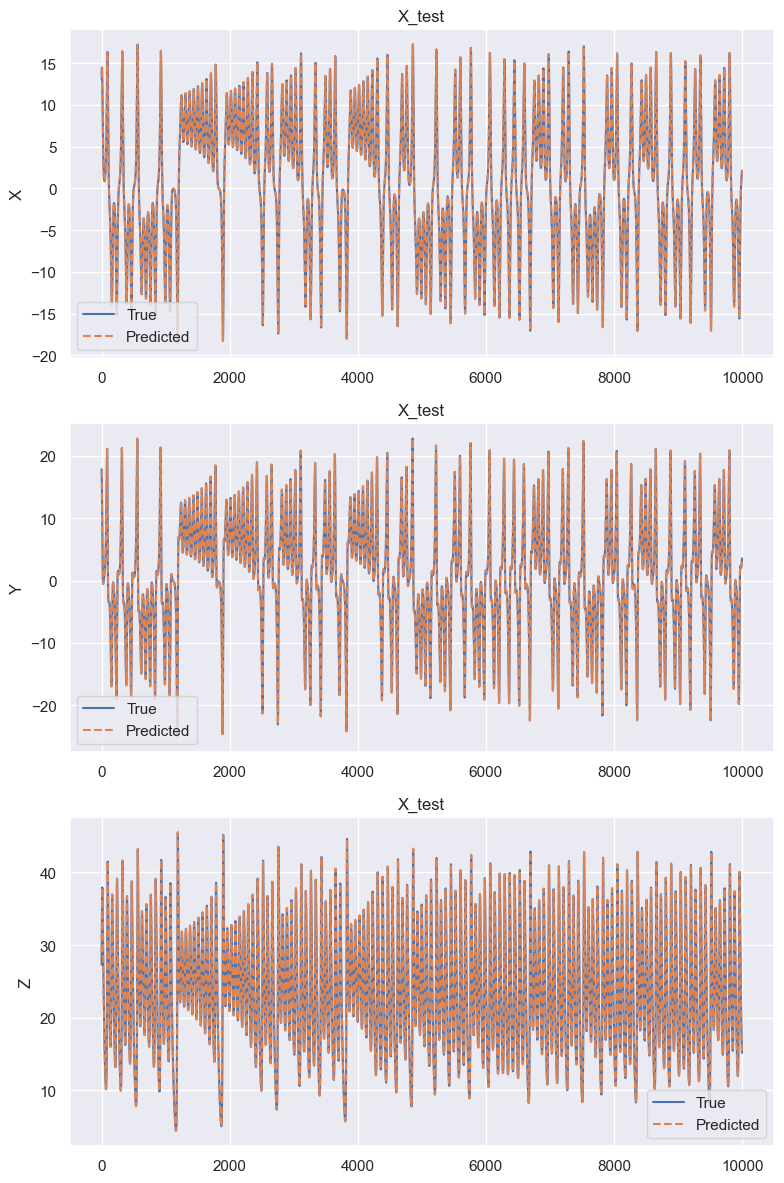

In [13]:
# Plot the predicted and true trajectories for X_test
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(X_test_plt[:, 0], label='True')
ax[0].plot(test_predictions_plt[:, 0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
ax[0].set_title('X_test')
ax[0].legend()

ax[1].plot(X_test_plt[:, 1], label='True')
ax[1].plot(test_predictions_plt[:, 1], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('X_test')
ax[1].legend()

ax[2].plot(X_test_plt[:, 2], label='True')
ax[2].plot(test_predictions_plt[:, 2], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
ax[2].set_title('X_test')
ax[2].legend()

plt.tight_layout()
plt.show()

## Projection-using-Trained-NeuralODE

In [23]:
def produce_trajectory(model, x_0, n_steps):
    X_hat = [x_0]
    for t in range(n_steps-1):
        y = model(x_0)
        X_hat.append(y)
        x_0 = y
    return torch.stack(X_hat)

final_model = net
L_test = X_test.shape[0]

X_hat = produce_trajectory(final_model, X_test[0], L_test)

In [24]:
X_hat_plt = X_hat.detach().numpy()

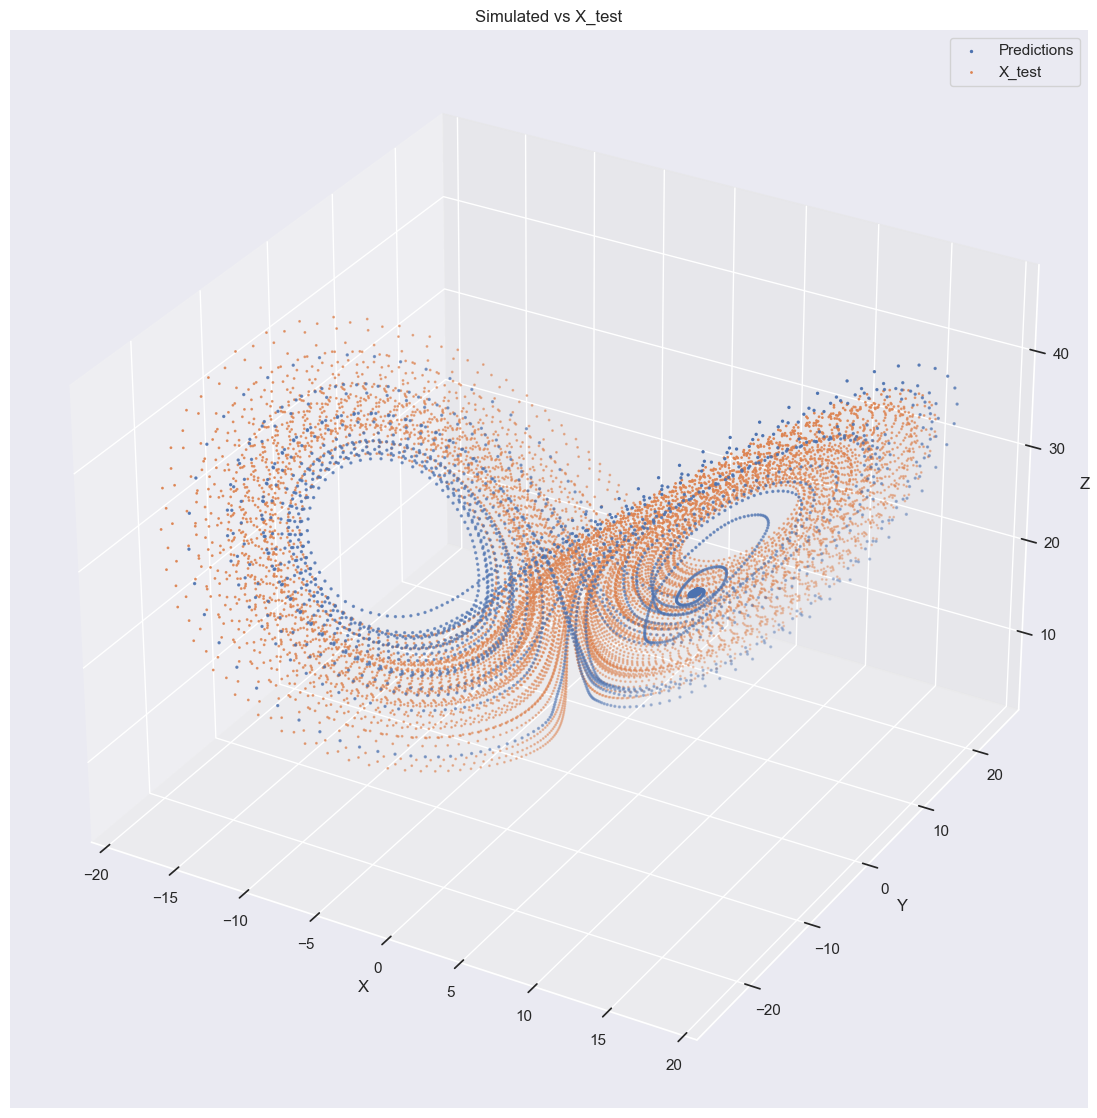

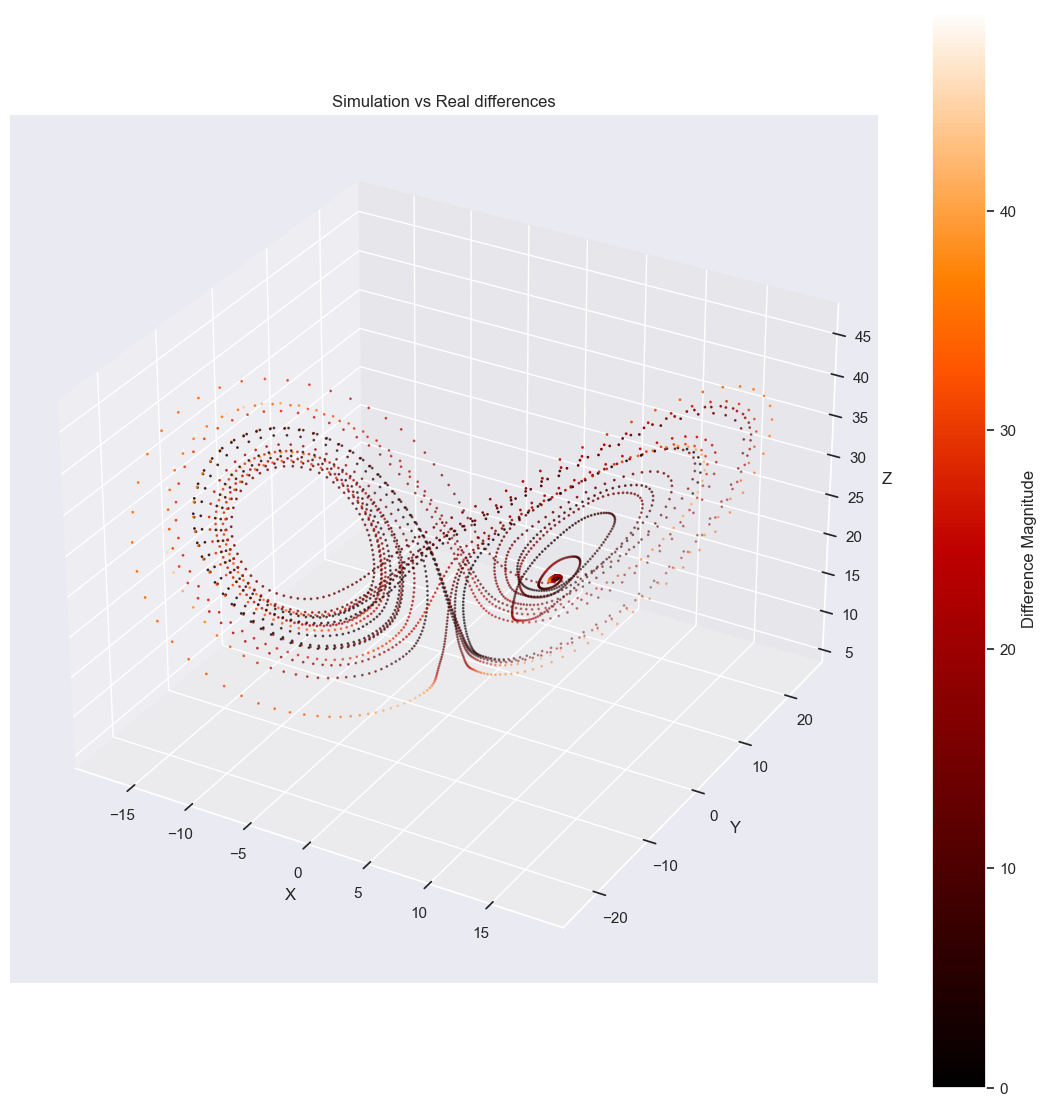

In [25]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = X_hat_plt[:, 0]
y_pred = X_hat_plt[:, 1]
z_pred = X_hat_plt[:, 2]

# Extract the x, y, z coordinates from X_train_plt
x_train = X_test_plt[:, 0]
y_train = X_test_plt[:, 1]
z_train = X_test_plt[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_pred, y_pred, z_pred, label='Predictions',s=2)
ax.scatter(x_train, y_train, z_train, label='X_test',s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulated vs X_test')
ax.legend()

# Show the plot
plt.show()

diff_x = x_pred - x_train
diff_y = y_pred - y_train
diff_z = z_pred - z_train

# Calculate the magnitude of the differences
diff_mag = np.sqrt(diff_x**2 + diff_y**2 + diff_z**2)

# Define the color map for differences
cmap = plt.cm.get_cmap('gist_heat')  # Choose a colormap (e.g., 'cool')

# Create a 3D plot with sparsity in visualizing differences
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_pred, y_pred, z_pred, c=diff_mag, cmap=cmap, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simulation vs Real differences')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Difference Magnitude')

# Show the plot
plt.show()






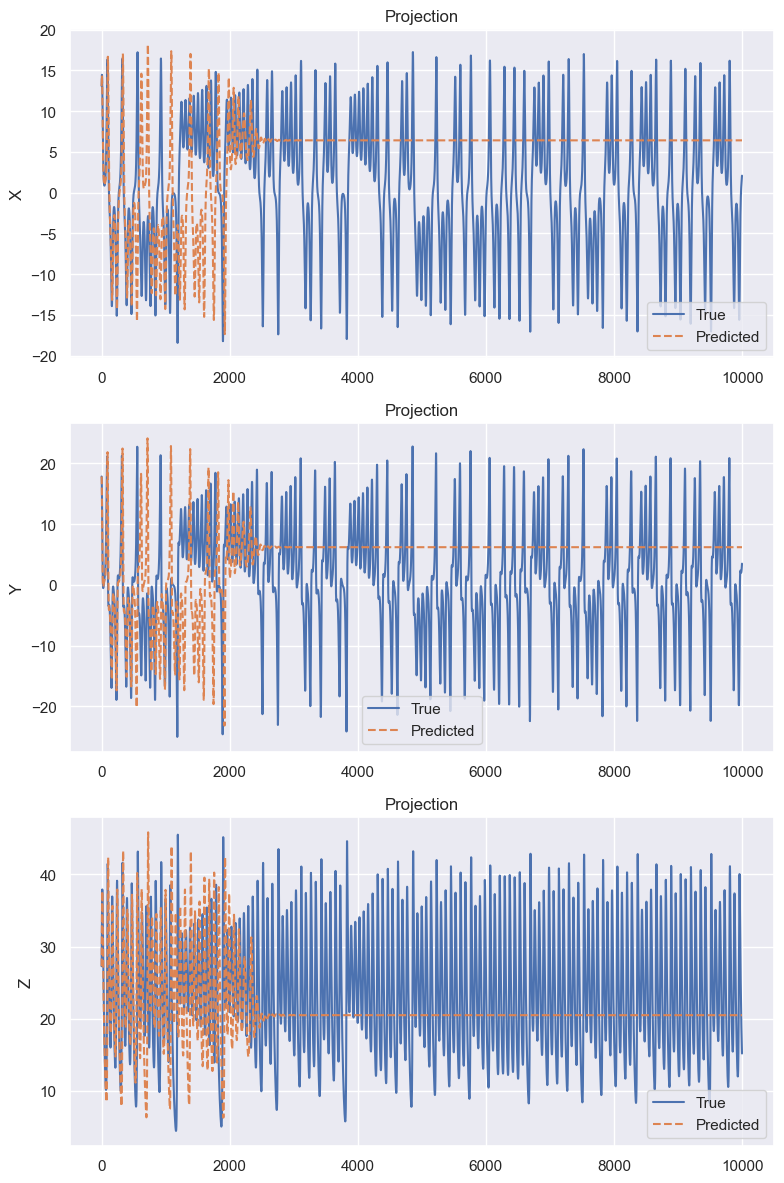

In [26]:
# Plot the predicted and true trajectories for X_test
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(X_test_plt[:, 0], label='True')
ax[0].plot(X_hat_plt[:, 0], label='Predicted',linestyle='--')
ax[0].set_ylabel('X')
#ax[0].set_xlim(0, 5000)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(X_test_plt[:, 1], label='True')
ax[1].plot(X_hat_plt[:, 1], label='Predicted',linestyle='--')
ax[1].set_ylabel('Y')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(X_test_plt[:, 2], label='True')
ax[2].plot(X_hat_plt[:, 2], label='Predicted',linestyle='--')
ax[2].set_ylabel('Z')
#ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()

plt.tight_layout()
plt.show()

## Conclusions:

1. Using NeuralODES we can get a good approximation of the Lorenz attractor as showcased by good performance on the test data.
2. However when using the trained NeuralODE network to produce a trajectory with initial conditions same as of test set and comparing with the ground truth, it appears it diverges usually after  1200 steps on different runs.
3. One possible reason may be small errors introduced in computaion make the model diverge in subsequent steps.
4. The accuracy and capability of model is dependent heavily on initial conditions, as in some cases the projection is just a circle.
5. As the task was not very memory intensive, odeint_adjoint method was not used.

Further analysis and comparison with models like RNN and LSTM should be done to better gauge the performance of neural ODE.


## References

* [Learning the Lorenz System](https://verzep.github.io/Learning-Lorenz/)
* Lana, X., Monterrubio-Velasco, M., & Arámbula-Mendoza, R. (2023). Uncertainties, complexities and possible forecasting of the volcán de Colima energy emissions (México, years 2013–2015) based on the fractal reconstruction theorem. *Nonlinear Processes in Geophysics*, 30(2), 101–181. https://doi.org/10.5194/npg-2019-23
* Hennigan, D., Chen, W., Rubanova, A., Bettencourt, J., Dupont, E., & Bengio, Y. (2018). Neural ordinary differential equations. *arXiv preprint arXiv:1806.07366*. [DOI](https://doi.org/10.48550/arXiv.1806.07366)
* Kidger, P. (2022). On Neural Differential Equations. *arXiv preprint arXiv:2202.02435*. [DOI](https://doi.org/10.48550/arXiv.2202.02435)
